📥 Chargement des données...
✓ Données prêtes : torch.Size([90, 1, 64, 641]) échantillons
🧠 Modèle EEGNetLight initialisé — 64 canaux, 641 temps, 3 classes
🧠 Epoch 01 — Loss: 24.6736 — Acc: 42.22%
🧠 Epoch 02 — Loss: 23.3244 — Acc: 50.00%
🧠 Epoch 03 — Loss: 21.3809 — Acc: 53.33%
🧠 Epoch 04 — Loss: 17.7818 — Acc: 67.78%
🧠 Epoch 05 — Loss: 15.0534 — Acc: 80.00%
🧠 Epoch 06 — Loss: 13.0926 — Acc: 85.56%
🧠 Epoch 07 — Loss: 10.6797 — Acc: 86.67%
🧠 Epoch 08 — Loss: 8.3771 — Acc: 90.00%
🧠 Epoch 09 — Loss: 5.8140 — Acc: 94.44%
🧠 Epoch 10 — Loss: 4.0713 — Acc: 97.78%

✅ Modèle Enregistré : ../../models/eegnet_subject1_simple.pth


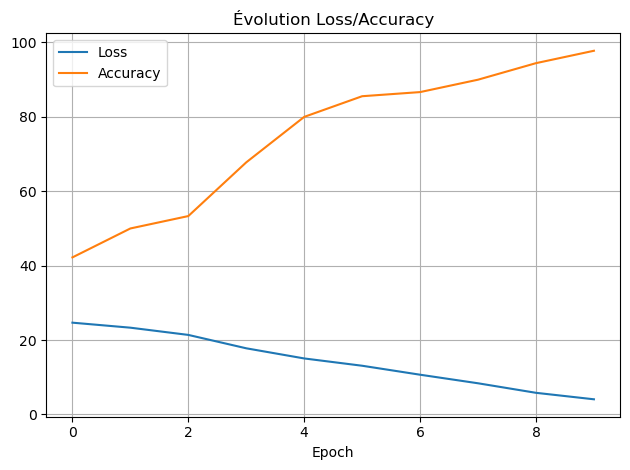

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os, sys
import matplotlib.pyplot as plt

# Patch anti-crash Intel/OpenMP
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Ajouter le dossier racine au path pour accéder à src/
sys.path.append(os.path.abspath(".."))
from src.models.eegnet import EEGNetLight

# Charger les données EEG (fichier unique)
print("📥 Chargement des données...")
data = np.load("../../data/processed/subject_1_epochs.npz")
X = data["X"]
y = data["y"]

# Préparation des tenseurs
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # [N, 1, C, T]
y_tensor = torch.tensor(y - y.min(), dtype=torch.long)        # correction des labels
print(f"✓ Données prêtes : {X_tensor.shape} échantillons")

# Dataset & DataLoader
ds = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(ds, batch_size=4, shuffle=True)  # 🔧 batch size réduit

# Initialiser le modèle
n_channels, n_timepoints = X.shape[1], X.shape[2]
n_classes = len(torch.unique(y_tensor))
model = EEGNetLight(n_channels=n_channels, n_timepoints=n_timepoints, n_classes=n_classes)
print(f"🧠 Modèle EEGNetLight initialisé — {n_channels} canaux, {n_timepoints} temps, {n_classes} classes")

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Entraînement
losses = []
accuracies = []
for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (preds.argmax(1) == yb).sum().item()
        total += yb.size(0)

    acc = 100 * correct / total
    losses.append(total_loss)
    accuracies.append(acc)
    print(f"🧠 Epoch {epoch+1:02d} — Loss: {total_loss:.4f} — Acc: {acc:.2f}%")

# Sauvegarde du modèle
os.makedirs("../../models", exist_ok=True)
torch.save(model.state_dict(), "../../models/eegnet_subject1_simple.pth")
print("\n✅ Modèle Enregistré : ../../models/eegnet_subject1_simple.pth")

# Courbe de suivi
plt.plot(losses, label='Loss')
plt.plot(accuracies, label='Accuracy')
plt.title("Évolution Loss/Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


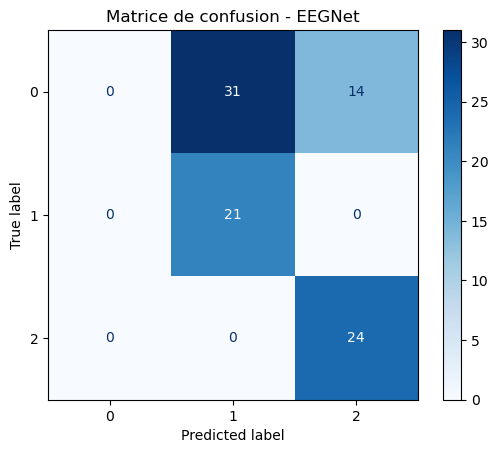

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prédictions globales
model.eval()
with torch.no_grad():
    all_preds = model(X_tensor).argmax(1)

# Matrice de confusion
cm = confusion_matrix(y_tensor, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - EEGNet")
plt.show()


In [3]:
np.savez("../../models/eegnet_subject1_simple_stats.npz",
         losses=np.array(losses),
         accuracies=np.array(accuracies))
print("📊 Courbes enregistrées dans eegnet_subject1_simple_stats.npz")


📊 Courbes enregistrées dans eegnet_subject1_simple_stats.npz


In [4]:
idx = 3
example = X_tensor[idx:idx+1]

model.eval()
with torch.no_grad():
    proba = torch.softmax(model(example), dim=1)

print(f"Vraie étiquette : {y_tensor[idx].item()} — Prédictions : {proba.numpy().round(3)}")


Vraie étiquette : 1 — Prédictions : [[0.    0.992 0.008]]


In [5]:
unique, counts = torch.unique(y_tensor, return_counts=True)
for cls, count in zip(unique.tolist(), counts.tolist()):
    print(f"Classe {cls} : {count} échantillons")


Classe 0 : 45 échantillons
Classe 1 : 21 échantillons
Classe 2 : 24 échantillons


In [6]:
from src.preprocessing.windowing import extract_epochs_from_annotations
import mne, os

subject = 1
runs = [6, 10, 14]
output_dir = "../../data/processed"
os.makedirs(output_dir, exist_ok=True)

for run in runs:
    files = mne.datasets.eegbci.load_data(subjects=[subject], runs=[run])
    raw = mne.io.read_raw_edf(files[0], preload=True)

    raw.rename_channels(lambda name: name.strip(".").upper())
    raw.set_montage("standard_1020", on_missing="ignore")

    X, y = extract_epochs_from_annotations(
        raw, tmin=0.0, tmax=4.0,
        output_path=os.path.join(output_dir, f"subject_{subject}_run_{run}_epochs.npz")
    )
    print(f"✅ Run {run} exporté : {X.shape} échantillons")


Extracting EDF parameters from C:\Users\Antoi\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
✅ Extraction des événements depuis les annotations...
✅ 30 événements détectés : {np.str_('T0'): 0, np.str_('T1'): 1, np.str_('T2'): 2}
📀 Sauvegarde effectuée dans : ../../data/processed\subject_1_run_6_epochs.npz
🔢 Extraction des données numpy : (30, 64, 641) — Labels : [0 1 2]
✅ Run 6 exporté : (30, 64, 641) échantillons
Extracting EDF parameters from C:\Users\Antoi\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
✅ Extraction des événements depuis les annotations...
✅ 30 événements détectés : {np.str_('T0'): 0, np.str_('T1'): 1, np.str_('T2'): 2}
📀 Sauvegarde effectuée dans : ../../d

🧠 Epoch 01 — Loss: 9.8711 — Acc: 41.67%
🧠 Epoch 02 — Loss: 9.4839 — Acc: 52.78%
🧠 Epoch 03 — Loss: 8.8912 — Acc: 52.78%
🧠 Epoch 04 — Loss: 8.3388 — Acc: 54.17%
🧠 Epoch 05 — Loss: 7.1497 — Acc: 61.11%
🧠 Epoch 06 — Loss: 5.8098 — Acc: 73.61%
🧠 Epoch 07 — Loss: 4.4884 — Acc: 81.94%
🧠 Epoch 08 — Loss: 3.6548 — Acc: 84.72%
🧠 Epoch 09 — Loss: 2.8067 — Acc: 93.06%
🧠 Epoch 10 — Loss: 2.2302 — Acc: 95.83%

✅ Modèle multirun sauvegardé dans : ../../models/eegnet_subject1_multirun.pth



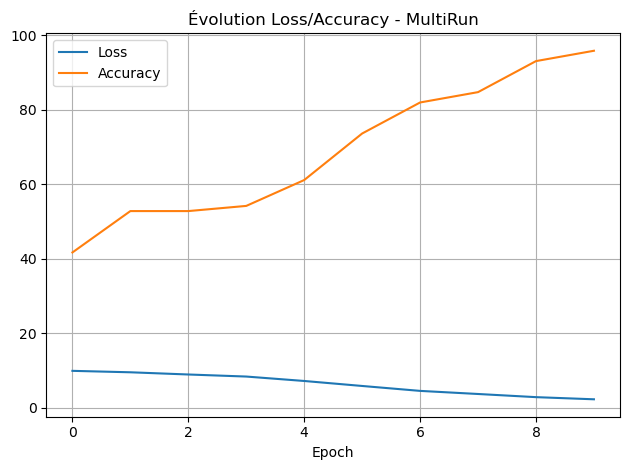

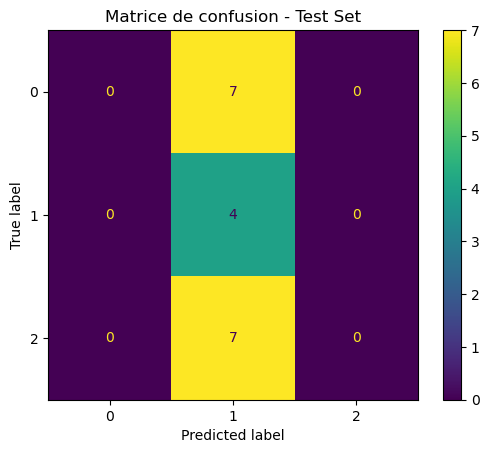


🔍 Exemple — Prédiction : [[0.    0.953 0.047]]


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, random_split
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ajouter le dossier racine au path pour accéder à src/
sys.path.append(os.path.abspath(".."))
from src.models.eegnet import EEGNetLight

def train_multirun():
    subject = 1
    runs = [6, 10, 14]
    data_dir = "../../data/processed"

    # Charger et concaténer les données de plusieurs runs
    datasets = []
    for run in runs:
        path = os.path.join(data_dir, f"subject_{subject}_run_{run}_epochs.npz")
        data = np.load(path)
        X = data["X"]
        y = data["y"] - data["y"].min()  # Corriger les labels si besoin
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        y_tensor = torch.tensor(y, dtype=torch.long)
        datasets.append(TensorDataset(X_tensor, y_tensor))

    # Concaténer tous les jeux de données
    full_ds = ConcatDataset(datasets)

    # Split entraînement/test (80/20)
    train_size = int(0.8 * len(full_ds))
    test_size = len(full_ds) - train_size
    train_ds, test_ds = random_split(full_ds, [train_size, test_size])
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=8)

    # Initialiser le modèle
    n_channels, n_timepoints = X.shape[1], X.shape[2]
    all_labels = torch.cat([d.tensors[1] for d in datasets])
    n_classes = len(torch.unique(all_labels))
    model = EEGNetLight(n_channels=n_channels, n_timepoints=n_timepoints, n_classes=n_classes)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    losses, accuracies = [], []

    # Entraînement
    for epoch in range(10):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)

        acc = 100 * correct / total
        losses.append(total_loss)
        accuracies.append(acc)
        print(f"🧠 Epoch {epoch+1:02d} — Loss: {total_loss:.4f} — Acc: {acc:.2f}%")

    # Sauvegarde
    model_path = "../../models/eegnet_subject1_multirun.pth"
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    torch.save(model.state_dict(), model_path)
    print(f"\n✅ Modèle multirun sauvegardé dans : {model_path}\n")

    # Courbes
    plt.plot(losses, label='Loss')
    plt.plot(accuracies, label='Accuracy')
    plt.title("Évolution Loss/Accuracy - MultiRun")
    plt.xlabel("Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Évaluation finale sur test set
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            y_true.extend(yb.numpy())
            y_pred.extend(preds.argmax(1).numpy())

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title("Matrice de confusion - Test Set")
    plt.grid(False)
    plt.show()

    # Exemple prédiction unique
    example = test_ds[0][0].unsqueeze(0)  # Ajouter batch dim
    with torch.no_grad():
        proba = torch.softmax(model(example), dim=1)
    print(f"\n🔍 Exemple — Prédiction : {proba.numpy().round(3)}")

if __name__ == "__main__":
    train_multirun()



===== Fold 1 =====
🧠 Fold 1 — Epoch 01 — Loss: 9.8314 — Acc: 48.61%
🧠 Fold 1 — Epoch 02 — Loss: 9.3956 — Acc: 50.00%
🧠 Fold 1 — Epoch 03 — Loss: 9.0492 — Acc: 50.00%
🧠 Fold 1 — Epoch 04 — Loss: 8.3387 — Acc: 51.39%
🧠 Fold 1 — Epoch 05 — Loss: 7.3559 — Acc: 69.44%
🧠 Fold 1 — Epoch 06 — Loss: 6.2354 — Acc: 80.56%
🧠 Fold 1 — Epoch 07 — Loss: 4.8825 — Acc: 83.33%
🧠 Fold 1 — Epoch 08 — Loss: 3.8275 — Acc: 88.89%
🧠 Fold 1 — Epoch 09 — Loss: 2.9647 — Acc: 90.28%
🧠 Fold 1 — Epoch 10 — Loss: 2.4280 — Acc: 91.67%


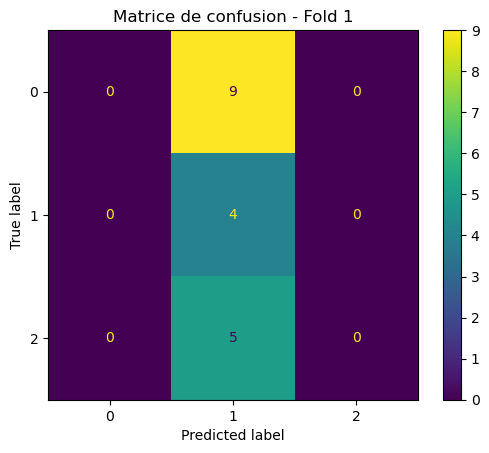

📦 Courbes sauvegardées dans eegnet_subject1_fold1_stats.npz

===== Fold 2 =====
🧠 Fold 2 — Epoch 01 — Loss: 9.8546 — Acc: 37.50%
🧠 Fold 2 — Epoch 02 — Loss: 9.3866 — Acc: 51.39%
🧠 Fold 2 — Epoch 03 — Loss: 8.6476 — Acc: 50.00%
🧠 Fold 2 — Epoch 04 — Loss: 7.6895 — Acc: 52.78%
🧠 Fold 2 — Epoch 05 — Loss: 6.3300 — Acc: 79.17%
🧠 Fold 2 — Epoch 06 — Loss: 4.9689 — Acc: 83.33%
🧠 Fold 2 — Epoch 07 — Loss: 3.9828 — Acc: 87.50%
🧠 Fold 2 — Epoch 08 — Loss: 3.0855 — Acc: 91.67%
🧠 Fold 2 — Epoch 09 — Loss: 2.3911 — Acc: 93.06%
🧠 Fold 2 — Epoch 10 — Loss: 1.8105 — Acc: 97.22%


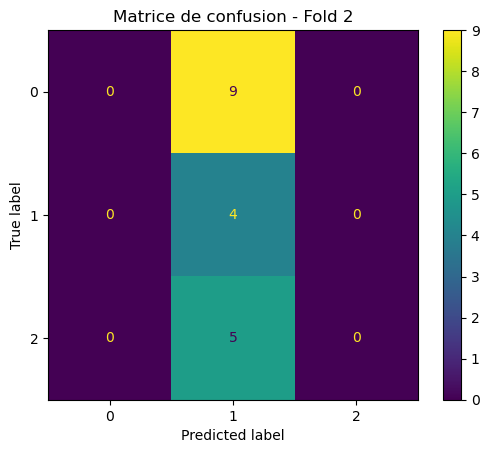

📦 Courbes sauvegardées dans eegnet_subject1_fold2_stats.npz

===== Fold 3 =====
🧠 Fold 3 — Epoch 01 — Loss: 9.8288 — Acc: 52.78%
🧠 Fold 3 — Epoch 02 — Loss: 9.4156 — Acc: 51.39%
🧠 Fold 3 — Epoch 03 — Loss: 8.7725 — Acc: 50.00%
🧠 Fold 3 — Epoch 04 — Loss: 8.0093 — Acc: 56.94%
🧠 Fold 3 — Epoch 05 — Loss: 6.6938 — Acc: 73.61%
🧠 Fold 3 — Epoch 06 — Loss: 5.5203 — Acc: 81.94%
🧠 Fold 3 — Epoch 07 — Loss: 4.7853 — Acc: 84.72%
🧠 Fold 3 — Epoch 08 — Loss: 3.8980 — Acc: 88.89%
🧠 Fold 3 — Epoch 09 — Loss: 3.3332 — Acc: 90.28%
🧠 Fold 3 — Epoch 10 — Loss: 2.6908 — Acc: 91.67%


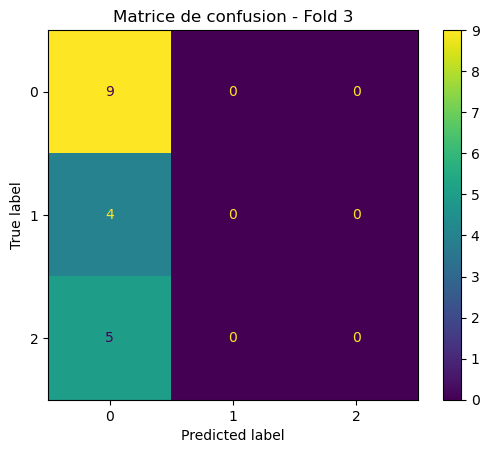

📦 Courbes sauvegardées dans eegnet_subject1_fold3_stats.npz

===== Fold 4 =====
🧠 Fold 4 — Epoch 01 — Loss: 9.8357 — Acc: 47.22%
🧠 Fold 4 — Epoch 02 — Loss: 9.4840 — Acc: 50.00%
🧠 Fold 4 — Epoch 03 — Loss: 8.7954 — Acc: 50.00%
🧠 Fold 4 — Epoch 04 — Loss: 7.8958 — Acc: 51.39%
🧠 Fold 4 — Epoch 05 — Loss: 6.4438 — Acc: 76.39%
🧠 Fold 4 — Epoch 06 — Loss: 5.3118 — Acc: 83.33%
🧠 Fold 4 — Epoch 07 — Loss: 4.3339 — Acc: 84.72%
🧠 Fold 4 — Epoch 08 — Loss: 3.6629 — Acc: 87.50%
🧠 Fold 4 — Epoch 09 — Loss: 3.0003 — Acc: 93.06%
🧠 Fold 4 — Epoch 10 — Loss: 2.0391 — Acc: 95.83%


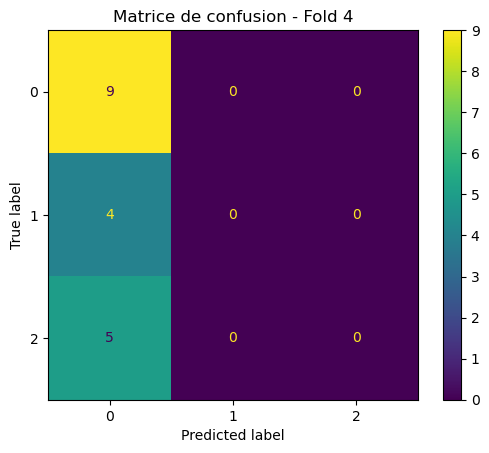

📦 Courbes sauvegardées dans eegnet_subject1_fold4_stats.npz

===== Fold 5 =====
🧠 Fold 5 — Epoch 01 — Loss: 9.8503 — Acc: 36.11%
🧠 Fold 5 — Epoch 02 — Loss: 9.4510 — Acc: 50.00%
🧠 Fold 5 — Epoch 03 — Loss: 8.8277 — Acc: 50.00%
🧠 Fold 5 — Epoch 04 — Loss: 8.0275 — Acc: 54.17%
🧠 Fold 5 — Epoch 05 — Loss: 6.9460 — Acc: 62.50%
🧠 Fold 5 — Epoch 06 — Loss: 5.6228 — Acc: 79.17%
🧠 Fold 5 — Epoch 07 — Loss: 4.7882 — Acc: 80.56%
🧠 Fold 5 — Epoch 08 — Loss: 3.7393 — Acc: 84.72%
🧠 Fold 5 — Epoch 09 — Loss: 2.9914 — Acc: 90.28%
🧠 Fold 5 — Epoch 10 — Loss: 2.3236 — Acc: 91.67%


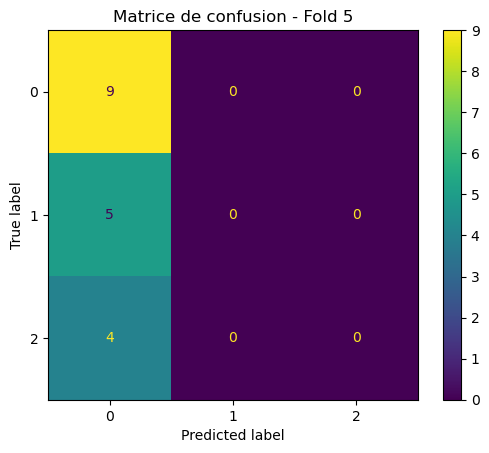

📦 Courbes sauvegardées dans eegnet_subject1_fold5_stats.npz

===== Résumé global sur 5 folds =====
📊 Moyenne des Loss : 2.2584 ± 0.3061
📈 Moyenne des Accuracy : 93.61% ± 2.42%


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Ajouter le dossier racine au path pour accéder à src/
sys.path.append(os.path.abspath(".."))
from src.models.eegnet import EEGNetLight

def train_multirun():
    subject = 1
    runs = [6, 10, 14]
    data_dir = "../../data/processed"

    # Charger et concaténer les données de plusieurs runs
    datasets = []
    for run in runs:
        path = os.path.join(data_dir, f"subject_{subject}_run_{run}_epochs.npz")
        data = np.load(path)
        X = data["X"]
        y = data["y"] - data["y"].min()
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        y_tensor = torch.tensor(y, dtype=torch.long)
        datasets.append(TensorDataset(X_tensor, y_tensor))

    full_X = torch.cat([d.tensors[0] for d in datasets])
    full_y = torch.cat([d.tensors[1] for d in datasets])

    # 1. Validation croisée stratifiée (5 folds)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold = 1
    all_losses = []
    all_accuracies = []

    for train_idx, test_idx in skf.split(full_X, full_y):
        print(f"\n===== Fold {fold} =====")
        X_train, y_train = full_X[train_idx], full_y[train_idx]
        X_test, y_test = full_X[test_idx], full_y[test_idx]

        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, shuffle=True)
        test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=8)

        # 2. Initialiser EEGNet
        n_channels, n_timepoints = X.shape[1], X.shape[2]
        n_classes = len(torch.unique(full_y))
        model = EEGNetLight(n_channels=n_channels, n_timepoints=n_timepoints, n_classes=n_classes)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        losses, accuracies = [], []

        for epoch in range(10):
            model.train()
            total_loss, correct, total = 0, 0, 0
            for xb, yb in train_loader:
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)
            acc = 100 * correct / total
            losses.append(total_loss)
            accuracies.append(acc)
            print(f"🧠 Fold {fold} — Epoch {epoch+1:02d} — Loss: {total_loss:.4f} — Acc: {acc:.2f}%")

        # 3. Analyse des erreurs
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                preds = model(xb)
                y_true.extend(yb.numpy())
                y_pred.extend(preds.argmax(1).numpy())

        cm = confusion_matrix(y_true, y_pred)
        ConfusionMatrixDisplay(cm).plot()
        plt.title(f"Matrice de confusion - Fold {fold}")
        plt.grid(False)
        plt.show()

        # 4. Exporter les stats
        np.savez(f"../../models/eegnet_subject{subject}_fold{fold}_stats.npz",
                 losses=np.array(losses), accuracies=np.array(accuracies))
        print(f"📦 Courbes sauvegardées dans eegnet_subject{subject}_fold{fold}_stats.npz")

        all_losses.append(losses[-1])
        all_accuracies.append(accuracies[-1])
        fold += 1

    # 5. Résumé global
    print("\n===== Résumé global sur 5 folds =====")
    print(f"📊 Moyenne des Loss : {np.mean(all_losses):.4f} ± {np.std(all_losses):.4f}")
    print(f"📈 Moyenne des Accuracy : {np.mean(all_accuracies):.2f}% ± {np.std(all_accuracies):.2f}%")

if __name__ == "__main__":
    train_multirun()



===== Fold 1 =====
🔢 Répartition y_train : tensor([36, 17, 19])
🔢 Répartition y_test  : tensor([9, 4, 5])
🧠 Fold 1 — Epoch 01 — Loss: 9.7841 — Acc: 36.11%
🧠 Fold 1 — Epoch 02 — Loss: 9.5144 — Acc: 41.67%
🧠 Fold 1 — Epoch 03 — Loss: 8.7528 — Acc: 56.94%
🧠 Fold 1 — Epoch 04 — Loss: 7.6266 — Acc: 51.39%
🧠 Fold 1 — Epoch 05 — Loss: 6.3685 — Acc: 55.56%
🧠 Fold 1 — Epoch 06 — Loss: 7.0283 — Acc: 56.94%
🧠 Fold 1 — Epoch 07 — Loss: 5.7200 — Acc: 73.61%
🧠 Fold 1 — Epoch 08 — Loss: 5.3507 — Acc: 75.00%
🧠 Fold 1 — Epoch 09 — Loss: 3.6575 — Acc: 84.72%
🧠 Fold 1 — Epoch 10 — Loss: 3.4578 — Acc: 86.11%


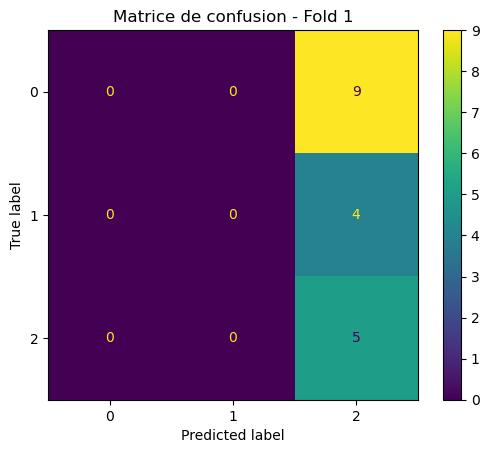


🔎 Rapport de classification :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         4
           2       0.28      1.00      0.43         5

    accuracy                           0.28        18
   macro avg       0.09      0.33      0.14        18
weighted avg       0.08      0.28      0.12        18

📦 Courbes sauvegardées dans eegnet_subject1_fold1_stats.npz

===== Fold 2 =====
🔢 Répartition y_train : tensor([36, 17, 19])
🔢 Répartition y_test  : tensor([9, 4, 5])
🧠 Fold 2 — Epoch 01 — Loss: 9.8118 — Acc: 37.50%
🧠 Fold 2 — Epoch 02 — Loss: 9.5135 — Acc: 51.39%
🧠 Fold 2 — Epoch 03 — Loss: 8.5370 — Acc: 65.28%
🧠 Fold 2 — Epoch 04 — Loss: 7.7343 — Acc: 62.50%
🧠 Fold 2 — Epoch 05 — Loss: 6.4057 — Acc: 62.50%
🧠 Fold 2 — Epoch 06 — Loss: 5.6490 — Acc: 75.00%
🧠 Fold 2 — Epoch 07 — Loss: 4.0173 — Acc: 79.17%
🧠 Fold 2 — Epoch 08 — Loss: 3.2822 — Acc: 86.11%
🧠 Fold 2 — Epoch 09 — Loss: 2

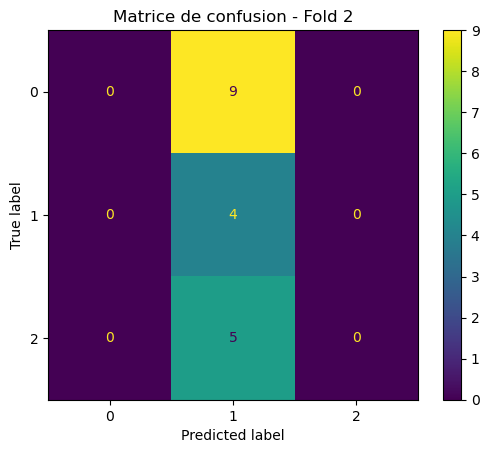


🔎 Rapport de classification :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.22      1.00      0.36         4
           2       0.00      0.00      0.00         5

    accuracy                           0.22        18
   macro avg       0.07      0.33      0.12        18
weighted avg       0.05      0.22      0.08        18

📦 Courbes sauvegardées dans eegnet_subject1_fold2_stats.npz

===== Fold 3 =====
🔢 Répartition y_train : tensor([36, 17, 19])
🔢 Répartition y_test  : tensor([9, 4, 5])
🧠 Fold 3 — Epoch 01 — Loss: 9.8125 — Acc: 40.28%
🧠 Fold 3 — Epoch 02 — Loss: 9.4859 — Acc: 36.11%
🧠 Fold 3 — Epoch 03 — Loss: 8.4250 — Acc: 47.22%
🧠 Fold 3 — Epoch 04 — Loss: 8.6516 — Acc: 36.11%
🧠 Fold 3 — Epoch 05 — Loss: 6.1536 — Acc: 69.44%
🧠 Fold 3 — Epoch 06 — Loss: 5.6236 — Acc: 73.61%
🧠 Fold 3 — Epoch 07 — Loss: 5.2443 — Acc: 70.83%
🧠 Fold 3 — Epoch 08 — Loss: 3.1133 — Acc: 87.50%
🧠 Fold 3 — Epoch 09 — Loss: 4

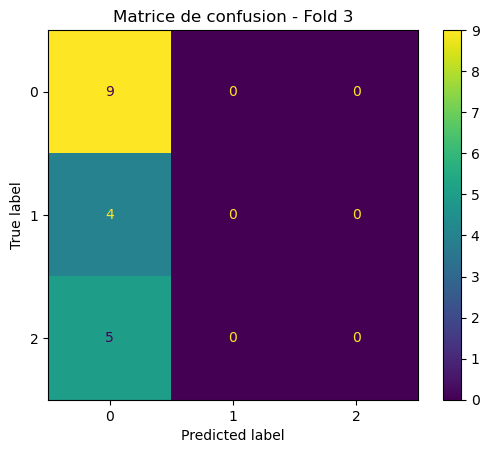


🔎 Rapport de classification :
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         9
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5

    accuracy                           0.50        18
   macro avg       0.17      0.33      0.22        18
weighted avg       0.25      0.50      0.33        18

📦 Courbes sauvegardées dans eegnet_subject1_fold3_stats.npz

===== Fold 4 =====
🔢 Répartition y_train : tensor([36, 17, 19])
🔢 Répartition y_test  : tensor([9, 4, 5])
🧠 Fold 4 — Epoch 01 — Loss: 9.7736 — Acc: 48.61%
🧠 Fold 4 — Epoch 02 — Loss: 8.9971 — Acc: 63.89%
🧠 Fold 4 — Epoch 03 — Loss: 7.7265 — Acc: 58.33%
🧠 Fold 4 — Epoch 04 — Loss: 8.5836 — Acc: 41.67%
🧠 Fold 4 — Epoch 05 — Loss: 7.7746 — Acc: 54.17%
🧠 Fold 4 — Epoch 06 — Loss: 6.0328 — Acc: 73.61%
🧠 Fold 4 — Epoch 07 — Loss: 4.9515 — Acc: 81.94%
🧠 Fold 4 — Epoch 08 — Loss: 3.4780 — Acc: 88.89%
🧠 Fold 4 — Epoch 09 — Loss: 3

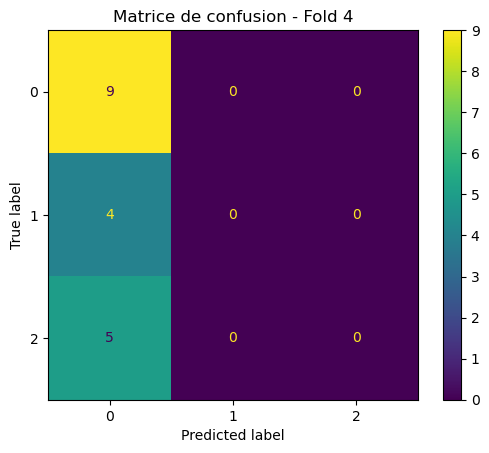


🔎 Rapport de classification :
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         9
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5

    accuracy                           0.50        18
   macro avg       0.17      0.33      0.22        18
weighted avg       0.25      0.50      0.33        18

📦 Courbes sauvegardées dans eegnet_subject1_fold4_stats.npz

===== Fold 5 =====
🔢 Répartition y_train : tensor([36, 16, 20])
🔢 Répartition y_test  : tensor([9, 5, 4])
🧠 Fold 5 — Epoch 01 — Loss: 9.8154 — Acc: 44.44%
🧠 Fold 5 — Epoch 02 — Loss: 9.4565 — Acc: 38.89%
🧠 Fold 5 — Epoch 03 — Loss: 9.5109 — Acc: 23.61%
🧠 Fold 5 — Epoch 04 — Loss: 8.4764 — Acc: 58.33%
🧠 Fold 5 — Epoch 05 — Loss: 7.2215 — Acc: 77.78%
🧠 Fold 5 — Epoch 06 — Loss: 6.0725 — Acc: 73.61%
🧠 Fold 5 — Epoch 07 — Loss: 3.8592 — Acc: 87.50%
🧠 Fold 5 — Epoch 08 — Loss: 3.6209 — Acc: 87.50%
🧠 Fold 5 — Epoch 09 — Loss: 2

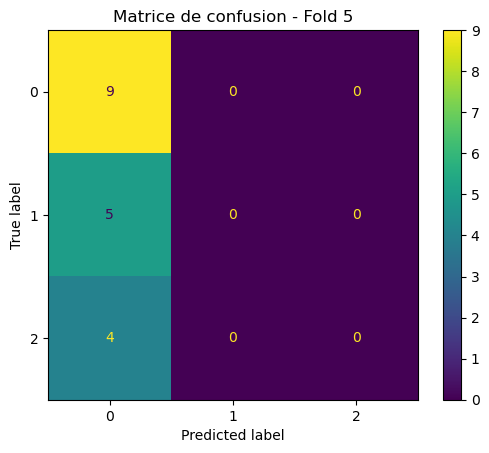


🔎 Rapport de classification :
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         9
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         4

    accuracy                           0.50        18
   macro avg       0.17      0.33      0.22        18
weighted avg       0.25      0.50      0.33        18

📦 Courbes sauvegardées dans eegnet_subject1_fold5_stats.npz


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, WeightedRandomSampler
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold

# Ajouter le dossier racine au path pour accéder à src/
sys.path.append(os.path.abspath(".."))
from src.models.eegnet import EEGNetLight

def train_multirun():
    subject = 1
    runs = [6, 10, 14]
    data_dir = "../../data/processed"

    # Charger et concaténer les données de plusieurs runs
    datasets = []
    for run in runs:
        path = os.path.join(data_dir, f"subject_{subject}_run_{run}_epochs.npz")
        data = np.load(path)
        X = data["X"]
        y = data["y"] - data["y"].min()
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        y_tensor = torch.tensor(y, dtype=torch.long)
        datasets.append(TensorDataset(X_tensor, y_tensor))

    full_X = torch.cat([d.tensors[0] for d in datasets])
    full_y = torch.cat([d.tensors[1] for d in datasets])

    # 1. Validation croisée stratifiée (5 folds)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold = 1
    for train_idx, test_idx in skf.split(full_X, full_y):
        print(f"\n===== Fold {fold} =====")
        X_train, y_train = full_X[train_idx], full_y[train_idx]
        X_test, y_test = full_X[test_idx], full_y[test_idx]

        print(f"🔢 Répartition y_train : {torch.bincount(y_train)}")
        print(f"🔢 Répartition y_test  : {torch.bincount(y_test)}")

        # Échantillonnage équilibré via WeightedRandomSampler
        class_sample_count = torch.bincount(y_train)
        weights = 1. / class_sample_count.float()
        sample_weights = weights[y_train]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, sampler=sampler)
        test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=8)

        # 2. Initialiser EEGNet avec pondération de classes
        n_channels, n_timepoints = X.shape[1], X.shape[2]
        n_classes = len(torch.unique(full_y))
        model = EEGNetLight(n_channels=n_channels, n_timepoints=n_timepoints, n_classes=n_classes)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        # Calcul des poids de classes inversés
        class_weights = 1. / class_sample_count.float()
        criterion = nn.CrossEntropyLoss(weight=class_weights)

        losses, accuracies = [], []

        for epoch in range(10):
            model.train()
            total_loss, correct, total = 0, 0, 0
            for xb, yb in train_loader:
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)
            acc = 100 * correct / total
            losses.append(total_loss)
            accuracies.append(acc)
            print(f"🧠 Fold {fold} — Epoch {epoch+1:02d} — Loss: {total_loss:.4f} — Acc: {acc:.2f}%")

        # 3. Analyse des erreurs
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                preds = model(xb)
                y_true.extend(yb.numpy())
                y_pred.extend(preds.argmax(1).numpy())

        cm = confusion_matrix(y_true, y_pred)
        ConfusionMatrixDisplay(cm).plot()
        plt.title(f"Matrice de confusion - Fold {fold}")
        plt.grid(False)
        plt.show()

        print("\n🔎 Rapport de classification :")
        print(classification_report(y_true, y_pred, zero_division=0))

        # 4. Exporter les stats
        np.savez(f"../../models/eegnet_subject{subject}_fold{fold}_stats.npz",
                 losses=np.array(losses), accuracies=np.array(accuracies))
        print(f"📦 Courbes sauvegardées dans eegnet_subject{subject}_fold{fold}_stats.npz")

        fold += 1

if __name__ == "__main__":
    train_multirun()



===== Fold 1 =====
🔢 Répartition y_train : tensor([36, 36])
🔢 Répartition y_test  : tensor([9, 9])
🧠 Fold 1 — Epoch 01 — Loss: 6.2181 — Acc: 51.39%
🧠 Fold 1 — Epoch 02 — Loss: 5.9626 — Acc: 81.94%
🧠 Fold 1 — Epoch 03 — Loss: 5.4687 — Acc: 84.72%
🧠 Fold 1 — Epoch 04 — Loss: 4.6722 — Acc: 81.94%
🧠 Fold 1 — Epoch 05 — Loss: 3.7323 — Acc: 84.72%
🧠 Fold 1 — Epoch 06 — Loss: 2.9871 — Acc: 87.50%
🧠 Fold 1 — Epoch 07 — Loss: 2.4144 — Acc: 88.89%
🧠 Fold 1 — Epoch 08 — Loss: 1.9750 — Acc: 93.06%
🧠 Fold 1 — Epoch 09 — Loss: 1.5844 — Acc: 93.06%
🧠 Fold 1 — Epoch 10 — Loss: 1.2285 — Acc: 97.22%


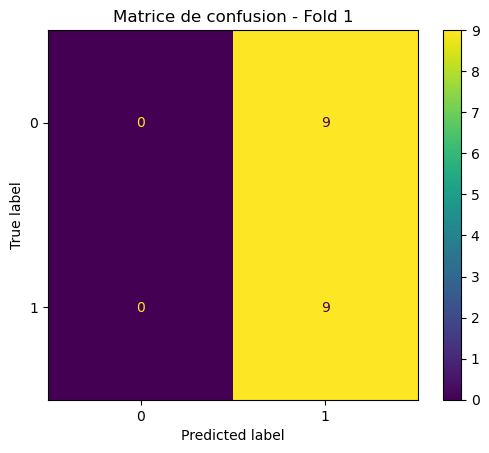


🔎 Rapport de classification :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.50      1.00      0.67         9

    accuracy                           0.50        18
   macro avg       0.25      0.50      0.33        18
weighted avg       0.25      0.50      0.33        18

📦 Courbes sauvegardées dans eegnet_subject1_fold1_stats.npz

===== Fold 2 =====
🔢 Répartition y_train : tensor([36, 36])
🔢 Répartition y_test  : tensor([9, 9])
🧠 Fold 2 — Epoch 01 — Loss: 6.2294 — Acc: 55.56%
🧠 Fold 2 — Epoch 02 — Loss: 6.1173 — Acc: 80.56%
🧠 Fold 2 — Epoch 03 — Loss: 5.7997 — Acc: 79.17%
🧠 Fold 2 — Epoch 04 — Loss: 5.1621 — Acc: 84.72%
🧠 Fold 2 — Epoch 05 — Loss: 4.4166 — Acc: 81.94%
🧠 Fold 2 — Epoch 06 — Loss: 3.4983 — Acc: 83.33%
🧠 Fold 2 — Epoch 07 — Loss: 3.0669 — Acc: 88.89%
🧠 Fold 2 — Epoch 08 — Loss: 2.5465 — Acc: 93.06%
🧠 Fold 2 — Epoch 09 — Loss: 2.2015 — Acc: 91.67%
🧠 Fold 2 — Epoch 10 — Loss: 2.0131 — Acc:

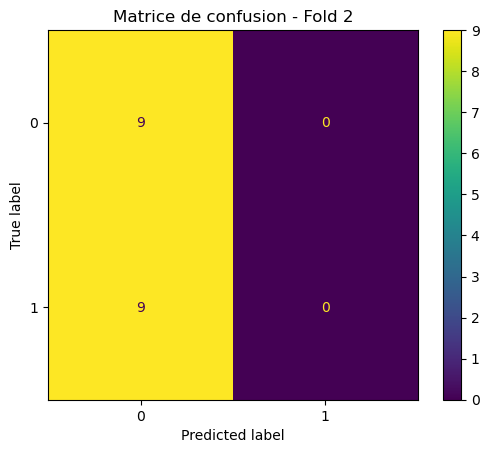


🔎 Rapport de classification :
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         9
           1       0.00      0.00      0.00         9

    accuracy                           0.50        18
   macro avg       0.25      0.50      0.33        18
weighted avg       0.25      0.50      0.33        18

📦 Courbes sauvegardées dans eegnet_subject1_fold2_stats.npz

===== Fold 3 =====
🔢 Répartition y_train : tensor([36, 36])
🔢 Répartition y_test  : tensor([9, 9])
🧠 Fold 3 — Epoch 01 — Loss: 6.2217 — Acc: 52.78%
🧠 Fold 3 — Epoch 02 — Loss: 6.0144 — Acc: 86.11%
🧠 Fold 3 — Epoch 03 — Loss: 5.5644 — Acc: 84.72%
🧠 Fold 3 — Epoch 04 — Loss: 4.8257 — Acc: 86.11%
🧠 Fold 3 — Epoch 05 — Loss: 3.7884 — Acc: 86.11%
🧠 Fold 3 — Epoch 06 — Loss: 3.0689 — Acc: 88.89%
🧠 Fold 3 — Epoch 07 — Loss: 2.6422 — Acc: 88.89%
🧠 Fold 3 — Epoch 08 — Loss: 2.1775 — Acc: 94.44%
🧠 Fold 3 — Epoch 09 — Loss: 1.8275 — Acc: 93.06%
🧠 Fold 3 — Epoch 10 — Loss: 1.6354 — Acc:

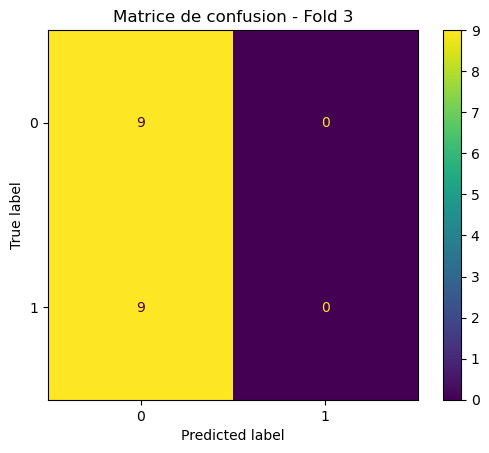


🔎 Rapport de classification :
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         9
           1       0.00      0.00      0.00         9

    accuracy                           0.50        18
   macro avg       0.25      0.50      0.33        18
weighted avg       0.25      0.50      0.33        18

📦 Courbes sauvegardées dans eegnet_subject1_fold3_stats.npz

===== Fold 4 =====
🔢 Répartition y_train : tensor([36, 36])
🔢 Répartition y_test  : tensor([9, 9])
🧠 Fold 4 — Epoch 01 — Loss: 6.2115 — Acc: 58.33%
🧠 Fold 4 — Epoch 02 — Loss: 5.9279 — Acc: 81.94%
🧠 Fold 4 — Epoch 03 — Loss: 5.3553 — Acc: 83.33%
🧠 Fold 4 — Epoch 04 — Loss: 4.5295 — Acc: 81.94%
🧠 Fold 4 — Epoch 05 — Loss: 3.4917 — Acc: 81.94%
🧠 Fold 4 — Epoch 06 — Loss: 2.9153 — Acc: 87.50%
🧠 Fold 4 — Epoch 07 — Loss: 2.4003 — Acc: 93.06%
🧠 Fold 4 — Epoch 08 — Loss: 1.9861 — Acc: 94.44%
🧠 Fold 4 — Epoch 09 — Loss: 1.6991 — Acc: 95.83%
🧠 Fold 4 — Epoch 10 — Loss: 1.1953 — Acc:

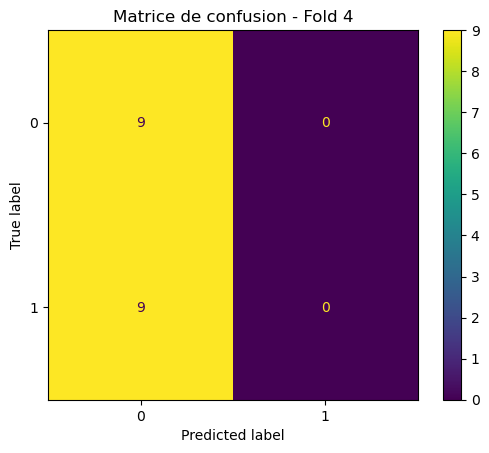


🔎 Rapport de classification :
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         9
           1       0.00      0.00      0.00         9

    accuracy                           0.50        18
   macro avg       0.25      0.50      0.33        18
weighted avg       0.25      0.50      0.33        18

📦 Courbes sauvegardées dans eegnet_subject1_fold4_stats.npz

===== Fold 5 =====
🔢 Répartition y_train : tensor([36, 36])
🔢 Répartition y_test  : tensor([9, 9])
🧠 Fold 5 — Epoch 01 — Loss: 6.1993 — Acc: 63.89%
🧠 Fold 5 — Epoch 02 — Loss: 5.9322 — Acc: 86.11%
🧠 Fold 5 — Epoch 03 — Loss: 5.3552 — Acc: 84.72%
🧠 Fold 5 — Epoch 04 — Loss: 4.4293 — Acc: 86.11%
🧠 Fold 5 — Epoch 05 — Loss: 3.5312 — Acc: 86.11%
🧠 Fold 5 — Epoch 06 — Loss: 3.2143 — Acc: 86.11%
🧠 Fold 5 — Epoch 07 — Loss: 2.9212 — Acc: 88.89%
🧠 Fold 5 — Epoch 08 — Loss: 2.5513 — Acc: 90.28%
🧠 Fold 5 — Epoch 09 — Loss: 2.2475 — Acc: 90.28%
🧠 Fold 5 — Epoch 10 — Loss: 2.0044 — Acc:

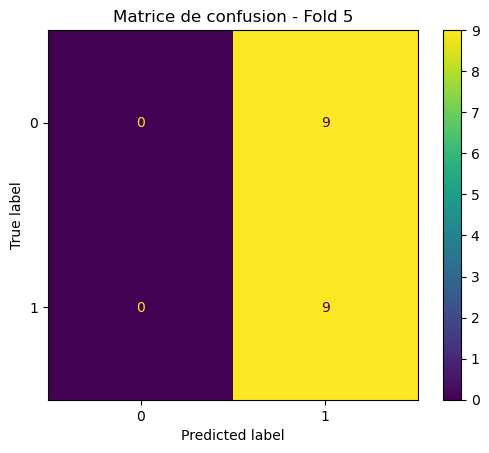


🔎 Rapport de classification :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.50      1.00      0.67         9

    accuracy                           0.50        18
   macro avg       0.25      0.50      0.33        18
weighted avg       0.25      0.50      0.33        18

📦 Courbes sauvegardées dans eegnet_subject1_fold5_stats.npz


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, Subset
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold

# Ajouter le dossier racine au path pour accéder à src/
sys.path.append(os.path.abspath(".."))
from src.models.eegnet import EEGNetLight

def train_multirun():
    subject = 1
    runs = [6, 10, 14]
    data_dir = "../../data/processed"

    # Charger et concaténer les données de plusieurs runs
    datasets = []
    for run in runs:
        path = os.path.join(data_dir, f"subject_{subject}_run_{run}_epochs.npz")
        data = np.load(path)
        X = data["X"]
        y = data["y"]
        # 🧠 Fusion des classes 1 et 2
        y = np.where(y == 2, 1, y)  # 2 → 1
        y = y - y.min()  # Correction pour que ça commence à 0
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        y_tensor = torch.tensor(y, dtype=torch.long)
        datasets.append(TensorDataset(X_tensor, y_tensor))

    full_X = torch.cat([d.tensors[0] for d in datasets])
    full_y = torch.cat([d.tensors[1] for d in datasets])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold = 1
    for train_idx, test_idx in skf.split(full_X, full_y):
        print(f"\n===== Fold {fold} =====")
        y_train, y_test = full_y[train_idx], full_y[test_idx]
        print(f"🔢 Répartition y_train : {torch.bincount(y_train)}")
        print(f"🔢 Répartition y_test  : {torch.bincount(y_test)}")

        train_loader = DataLoader(Subset(TensorDataset(full_X, full_y), train_idx), batch_size=8, shuffle=True)
        test_loader = DataLoader(Subset(TensorDataset(full_X, full_y), test_idx), batch_size=8)

        n_channels, n_timepoints = full_X.shape[2], full_X.shape[3]
        n_classes = len(torch.unique(full_y))
        model = EEGNetLight(n_channels=n_channels, n_timepoints=n_timepoints, n_classes=n_classes)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        losses, accuracies = [], []

        for epoch in range(10):
            model.train()
            total_loss, correct, total = 0, 0, 0
            for xb, yb in train_loader:
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)
            acc = 100 * correct / total
            losses.append(total_loss)
            accuracies.append(acc)
            print(f"🧠 Fold {fold} — Epoch {epoch+1:02d} — Loss: {total_loss:.4f} — Acc: {acc:.2f}%")

        # Évaluation
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                preds = model(xb)
                y_true.extend(yb.numpy())
                y_pred.extend(preds.argmax(1).numpy())

        # Matrice de confusion et rapport
        cm = confusion_matrix(y_true, y_pred)
        ConfusionMatrixDisplay(cm).plot()
        plt.title(f"Matrice de confusion - Fold {fold}")
        plt.grid(False)
        plt.show()

        print("\n🔎 Rapport de classification :")
        print(classification_report(y_true, y_pred, zero_division=0))

        # Exporter stats
        np.savez(f"../../models/eegnet_subject{subject}_fold{fold}_stats.npz",
                 losses=np.array(losses), accuracies=np.array(accuracies))
        print(f"📦 Courbes sauvegardées dans eegnet_subject{subject}_fold{fold}_stats.npz")

        fold += 1

if __name__ == "__main__":
    train_multirun()


In [11]:
import mne
import os
from src.preprocessing.windowing import extract_epochs_from_annotations

subject = 1
runs = [6, 10, 14]
output_dir = "../../data/processed"
os.makedirs(output_dir, exist_ok=True)

for run in runs:
    files = mne.datasets.eegbci.load_data(subjects=[subject], runs=[run])
    raw = mne.io.read_raw_edf(files[0], preload=True)
    raw.rename_channels(lambda name: name.strip(".").upper())
    raw.set_montage("standard_1020", on_missing="ignore")

    X, y = extract_epochs_from_annotations(
        raw, tmin=0.0, tmax=4.0,
        output_path=os.path.join(output_dir, f"subject_{subject}_run_{run}_epochs.npz")
    )
    print(f"✅ Run {run} exporté : {X.shape} échantillons")


Extracting EDF parameters from C:\Users\Antoi\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
✅ Extraction des événements depuis les annotations...
✅ 30 événements détectés : {np.str_('T0'): 0, np.str_('T1'): 1, np.str_('T2'): 2}
📀 Sauvegarde effectuée dans : ../../data/processed\subject_1_run_6_epochs.npz
🔢 Extraction des données numpy : (30, 64, 641) — Labels : [0 1 2]
✅ Run 6 exporté : (30, 64, 641) échantillons
Extracting EDF parameters from C:\Users\Antoi\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
✅ Extraction des événements depuis les annotations...
✅ 30 événements détectés : {np.str_('T0'): 0, np.str_('T1'): 1, np.str_('T2'): 2}
📀 Sauvegarde effectuée dans : ../../d